In this notebook, I approach the house prices competition on Kaggle using XGBoost. This is a powerful ensemble learning method, but seems to have a propensity to overfit. The exploratory data analysis and cleaning is the same as in the basic linear regression notebook, so this is cut and pasted. 

All of my notebooks are work-in-progress, but this one is in particular. I need to come back to it to prevent the extremely strong overfitting which happens if you just run the naive model. 

In [43]:
import numpy as np
import pandas as pd
from math import log
%matplotlib inline 
import matplotlib.pyplot as plt
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings('ignore')


train_data = pd.read_csv("home-data-for-ml-course/train.csv")
test_data = pd.read_csv("home-data-for-ml-course/test.csv")

pd.set_option('display.max_columns', None)
train_data = train_data.copy()
test_data = test_data.copy()
train_data.set_index('Id', inplace = True)
test_data.set_index('Id', inplace = True);

In the following, it is not necessary to normalise or transform the data, as it was when we used a linear regression model, since we are using XGBoostRegressor, which is based on decision trees. On the other hand, feature selection is important. To start with, I will just throw all the features in with the understanding that it will wildly overfit the data. From there, I can figure out which features are important and refine my model. 

In [44]:
y = train_data.SalePrice
train_data.drop('SalePrice',axis = 1,inplace = True)

In [45]:
categorical_cols = [cname for cname in train_data.columns if train_data[cname].nunique() < 10 and 
                        train_data[cname].dtype == "object"]
numerical_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]

my_cols = categorical_cols + numerical_cols
train_data_prepared = train_data[my_cols].copy()

In [46]:
numerical_transformer = SimpleImputer(strategy = 'mean')
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [119]:
"""
In the following, it was taking far too long to do a cross valdiation search on all of the parameters, so I did each sequentially, added
that parameter value to the model, and then did another cross validation search. The parameters below is the result of this. It's possible
that a different combination of parameters would have been better, but this would have taken too long to train. In particular, it seems 
reasonable that n_estimators and subsample could be optimised together. 

Finally, note that it doesn't make sense to do a cross validation grid search on an empty set of parameters, as is written in this cell.
This is just the result of the above process of iteratively searching each parameter to be able to tune these hyperparameters in 
a reasonable amount of time. 
"""

from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2

X_train, X_test, y_train, y_test = train_test_split(train_data_prepared, y, train_size = 0.8, random_state = 42)

model = XGBRegressor(colsample_bytree=0.4, subsample=0.6, reg_lambda=0.45,
                    eta = 0.041753189365604, gamma = 0.75, max_depth = 3, min_child_weight = 1.1, n_estimators = 775)
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('std_scaler', StandardScaler()),
                              ('model', model)
                             ])

parameters={}

gs = GridSearchCV(my_pipeline, param_grid = parameters, scoring = 'neg_mean_squared_error', cv = 5)
gs.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(),
                                                                         ['MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'BsmtFinSF1',
                                                                          'BsmtFinSF2',
                                                                          'BsmtUnfSF',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          '2ndFlrSF',
                                                                          'LowQualFinSF',
                                                                          'GrLivArea',
                                                                          'BsmtFullBath',
                                                                          'BsmtHalfBath...
                                                     importance_type=None,
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_bin=None,
                                                     max_cat_threshold=None,
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=3,
                                                     max_leaves=None,
                                                     min_child_weight=1.1,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=775,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             param_grid={}, scoring='neg_mean_squared_error')

{}


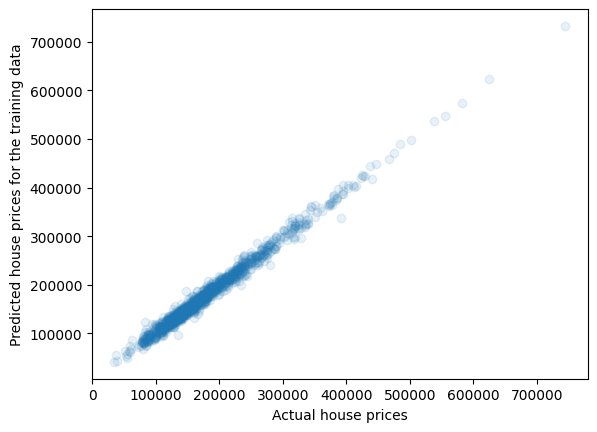

RMSE of the training data is: 0.05774108167641939


In [120]:
gs.best_score_
best_pipeline = gs.best_estimator_
print(gs.best_params_)

y_predict = best_pipeline.predict(X_train)

RMSE = mean_squared_error(np.log(y_predict), np.log(y_train))**0.5
plt.scatter(y_train, y_predict, alpha = 0.1)
plt.xlabel("Actual house prices")
plt.ylabel("Predicted house prices for the training data")
plt.show()
print(f"RMSE of the training data is: {RMSE}")

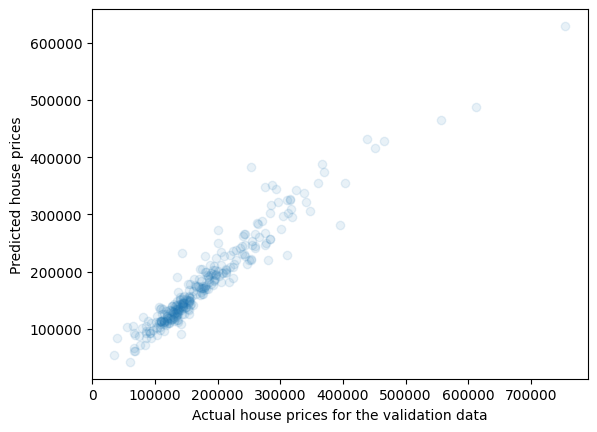

RMSE of the training data is: 0.13371425565671735


In [121]:
y_predict = best_pipeline.predict(X_test)
RMSE = mean_squared_error(np.log(y_predict), np.log(y_test))**0.5
plt.scatter(y_test, y_predict, alpha = 0.1)
plt.xlabel("Actual house prices for the validation data")
plt.ylabel("Predicted house prices")
plt.show()
print(f"RMSE of the training data is: {RMSE}")

This is still really very strongly overfit, but I believe that it's better than before. Two probably strongly related points which 
would improve the model are the following. 
* By feeding the model all of the data in an unfiltered way, it will almost certainly fit itself to noise in the data. As in the linear regression model, using all of the features is just too complex, and so feature selection is important.
* Continuing on from the above, we should pick the most important features to include in a more refined model with fewer features; however, the features which the above model thinks is important seems a bit out-of-whack. For example, it gives to value to the feature GrLivArea, signals there is an issue. Given that XGBoost is a tree regressor, it seems like there might be several natural metrics for 'most important'. For example, how many times the data is split on that feature, or what the average information gain is on splitting on that feature. I'm not sure which metric would make the most sense in this instance, but I am fairly confident that I would like the model to class GrLivArea as an important feature. 

Even though the model is clearly very overfit, the score on the test set is still better than linear regression models, so I will see how it goes in the competition. Now that I think that I've found the best collection of parameters, I should train the model on the whole collection of training data with these parameters. 

In [122]:
model = XGBRegressor(colsample_bytree=0.4, subsample=0.6, reg_lambda=0.45,
                    eta = 0.041753189365604, gamma = 0.75, max_depth = 3, min_child_weight = 1.1, n_estimators = 775)
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('std_scaler', StandardScaler()),
                              ('model', model)
                             ])
my_pipeline.fit(train_data_prepared, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath', 'Bed...
                              eval_metric=None, feature_types=None, gamma=0.75,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=1.01, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=775, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [123]:
output = my_pipeline.predict(test_data)
my_submission = pd.DataFrame({'Id': test_data.index, 'SalePrice': output})
my_submission.to_csv('XGBoostWithRegularisation.csv', index = False)


This gets a score of .13049, which is a modest improvement on the best score from any linear model. Nevertheless, it is still not a good score. It seems like a very bad practice to extremely overfit the data and rely on the error between training and new data to be big, but still to produce a better prediction than a model with higher bias and lower variance. 